In [ ]:
#! pip install tensorflow tensorflow-cpu matplotlib tensorflow-datasets ipywidgets

^C


In [38]:
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


In [1]:
import tensorflow as tf

# Check if TensorFlow detects a GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# More detailed info
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU: {gpu}")


GPU Available: []


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured with memory growth")
else:
    print("No GPU detected")

No GPU detected


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
#(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()

In [17]:
(mnist_train_images,_), (mnist_test_images,_) = keras.datasets.mnist.load_data()

In [ ]:
print("Data shape:", mnist_train_images.shape)

Data shape: (60000,)


In [ ]:
print("Data shape:", mnist_test_images.shape)

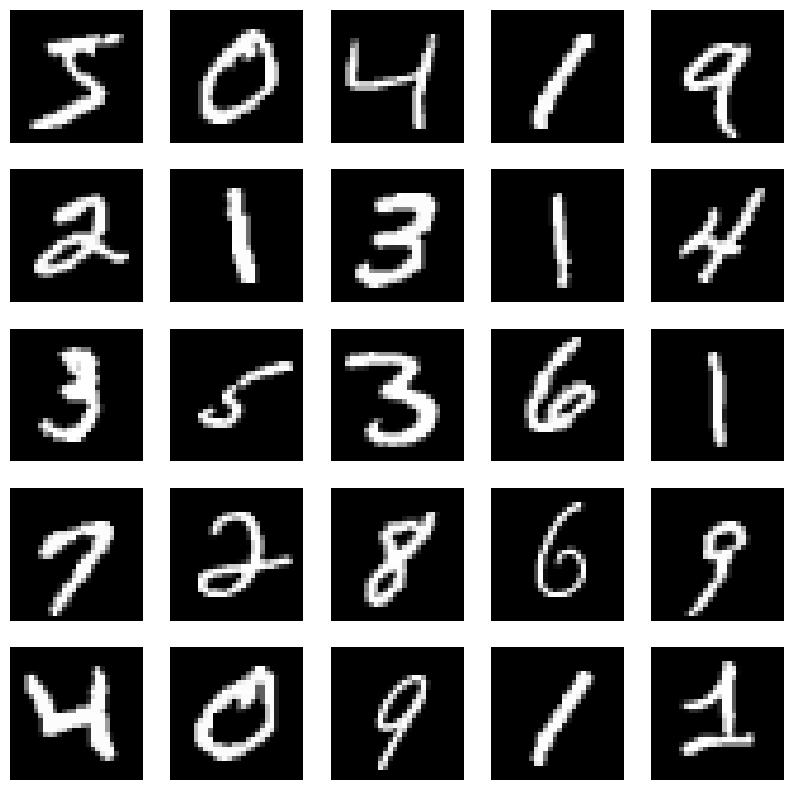

In [20]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5,5, i +1)
    plt.imshow(mnist_train_images[i], cmap='gray')
    plt.axis('off')
plt.show()

In [21]:
mnist_train_images.shape[0]

60000

In [26]:
mnist_train_images =  mnist_train_images.reshape(mnist_train_images.shape[0], 28, 28, 1).astype('float32')
mnist_train_images= (mnist_train_images - 127.5) / 127.5

In [28]:
mnist_train_images.shape

(60000, 28, 28, 1)

In [29]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [30]:
mnist_train_images

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices(mnist_train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [34]:
LATENT_DIM = 100
WEIGHT_UNIT= keras.initializers.RandomNormal(mean=0.01, stddev=0.02)

In [41]:
def build_generator():
  model = keras.Sequential([
    layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)),
    layers.BatchNormalization(), # normalize the activation of the previous layer
    layers.LeakyReLU(),

    layers.Reshape((7, 7, 256)),

    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
  return model

generator = build_generator()

c:\Users\agboo\.conda\envs\openvino\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
# build our discriminator
def build_discriminator():
  model = keras.Sequential([
      # First COnv2d layer: Detect low level features in the images (edges, textures, ...)
      layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),

      # LeakyRelu activation function to avoid dead neurons and allow negative gradients
      layers.LeakyReLU(0.2),
      # dropout to prevent overfitting and improve generalization
      layers.Dropout(0.3),

      # First COnv2d layer: learn more complex feature from the images
      layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.3),

      # Flatten the 2D feature maps into a 1D vector for the Dense layer
      layers.Flatten(),

      layers.Dense(1, activation='sigmoid')

  ])

  return model

discriminator = build_discriminator()

c:\Users\agboo\.conda\envs\openvino\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
cross_entropy = keras.losses.BinaryCrossentropy()

In [63]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [46]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [50]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.05)


In [64]:
# Building our sub ckass model
class GAN(keras.Model):
  def __init__(self, generator, discriminator):
    # initilize the GAN model  with the generator and discriminator
    super(GAN, self).__init__()
    self.generator = generator #set genrator model
    self.discriminator = discriminator # set discriminator moel


  def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
    super(GAN, self).compile()
    self.g_optimizer = g_optimizer # set the generator optimizer
    self.d_optimizer = d_optimizer # set the discriminator optimizer
    self.g_loss = g_loss # set the generator loss
    self.d_loss = d_loss # set the discriminator loss


  def train_step(self, real_images):
    # Training logic
    batch_size = tf.shape(real_images)[0]

    # Train discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as d_tape:
        generated_images = self.generator(noise)
        real_output = self.discriminator(real_images)
        fake_output = self.discriminator(generated_images)
        d_loss = self.d_loss(real_output, fake_output)

    # Cimputing the gradients for the discriminator based in its loss
    d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_images = self.generator(noise)
        fake_output = self.discriminator(generated_images)
        g_loss = self.g_loss(fake_output)

    g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_loss": g_loss}

In [65]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_images=16, latent_dim=100):
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.seed = tf.random.normal([num_images, latent_dim])

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      generated_images = self.model.generator(self.seed)
      generated_images = (generated_images * 127.5) + 127.5 #rescaleto range [0, 233]

      plt.figure(figsize=(10,10))
      for i in range(self.num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
      plt.show()

In [66]:
EPOCH = 100

In [67]:
gan = GAN(generator=generator, discriminator=discriminator)

gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.1056 - g_loss: 0.9011

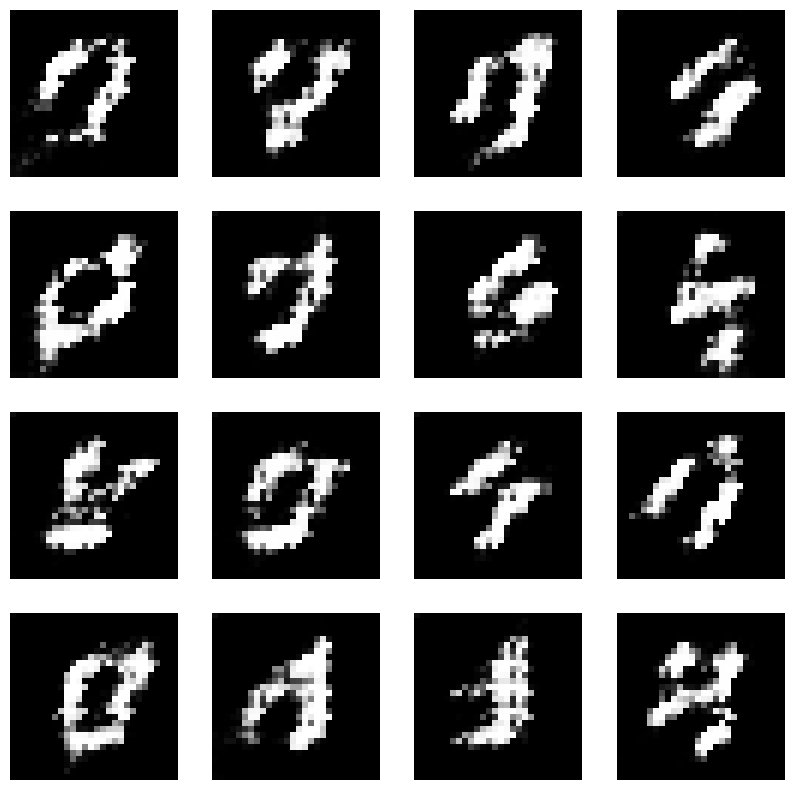

235/235 ━━━━━━━━━━━━━━━━━━━━ 523s 2s/step - d_loss: 1.1064 - g_loss: 0.9026
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - d_loss: 1.2625 - g_loss: 0.8594
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - d_loss: 1.2685 - g_loss: 0.8586
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - d_loss: 1.3032 - g_loss: 0.7939
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - d_loss: 1.3274 - g_loss: 0.7591
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3257 - g_loss: 0.7630

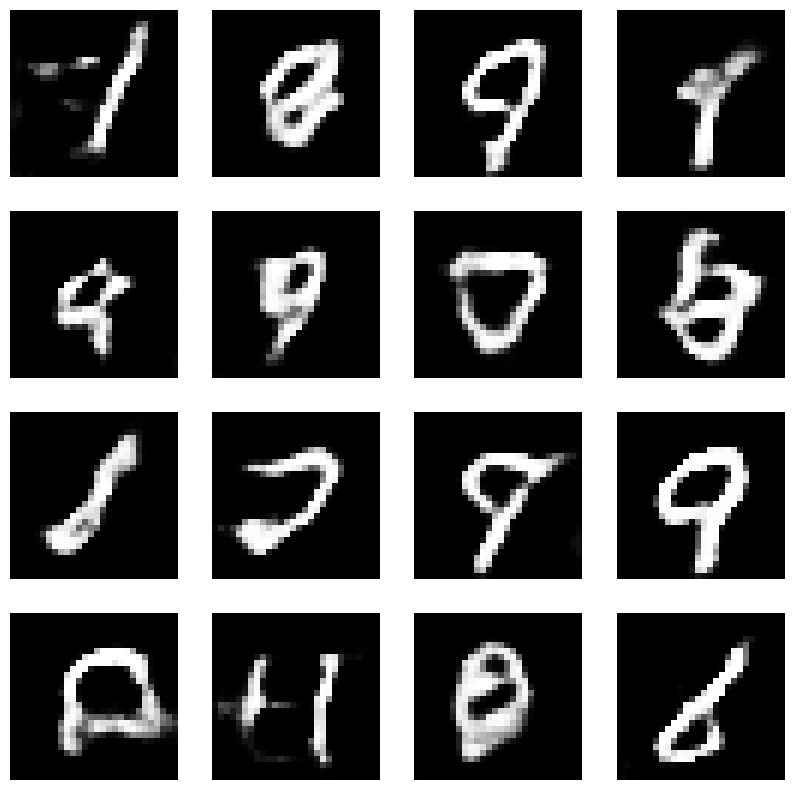

235/235 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - d_loss: 1.3257 - g_loss: 0.7621
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - d_loss: 1.3181 - g_loss: 0.7648
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - d_loss: 1.3136 - g_loss: 0.7752
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - d_loss: 1.3103 - g_loss: 0.7745
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - d_loss: 1.3073 - g_loss: 0.7830
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3095 - g_loss: 0.7825

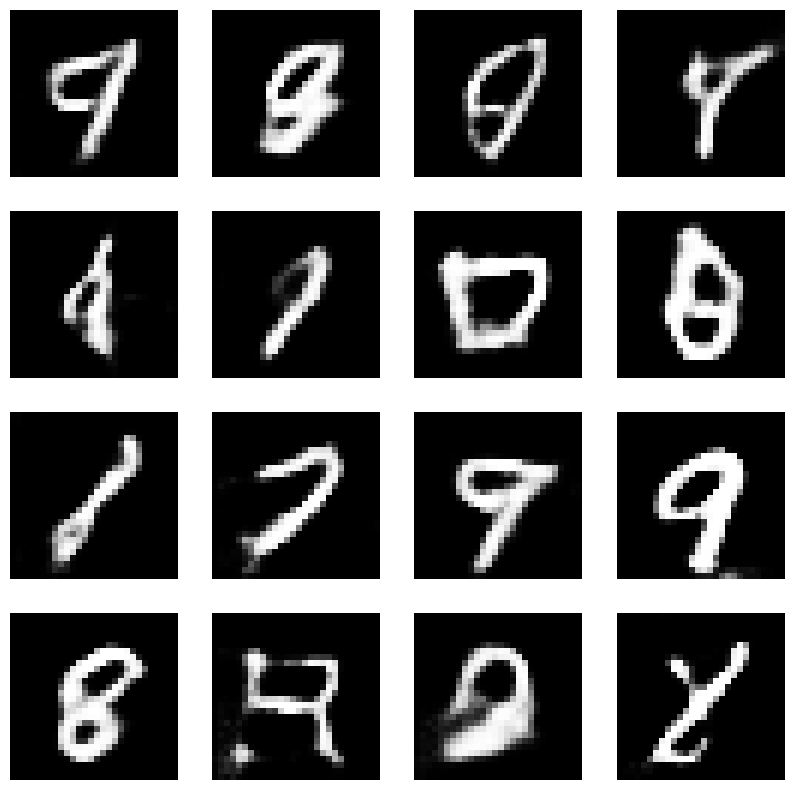

235/235 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - d_loss: 1.3094 - g_loss: 0.7825
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - d_loss: 1.3085 - g_loss: 0.7842
Epoch 13/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - d_loss: 1.3110 - g_loss: 0.7829
Epoch 14/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - d_loss: 1.3162 - g_loss: 0.7852
Epoch 15/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - d_loss: 1.3172 - g_loss: 0.7810
Epoch 16/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3209 - g_loss: 0.7785

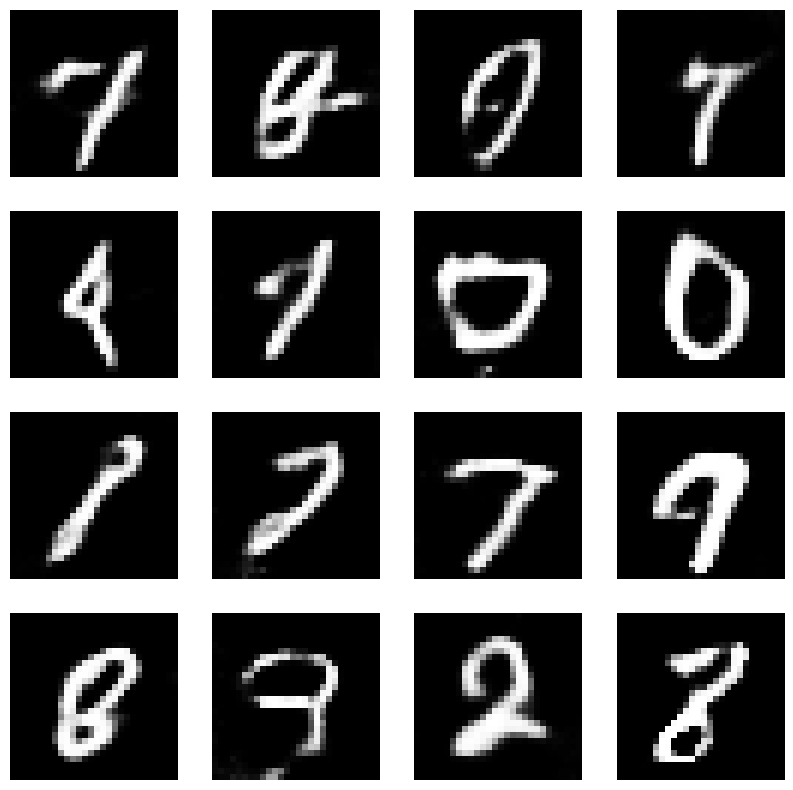

235/235 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - d_loss: 1.3207 - g_loss: 0.7782
Epoch 17/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - d_loss: 1.3219 - g_loss: 0.7786
Epoch 18/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - d_loss: 1.3233 - g_loss: 0.7745
Epoch 19/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - d_loss: 1.3246 - g_loss: 0.7761
Epoch 20/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - d_loss: 1.3267 - g_loss: 0.7735
Epoch 21/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3254 - g_loss: 0.7749

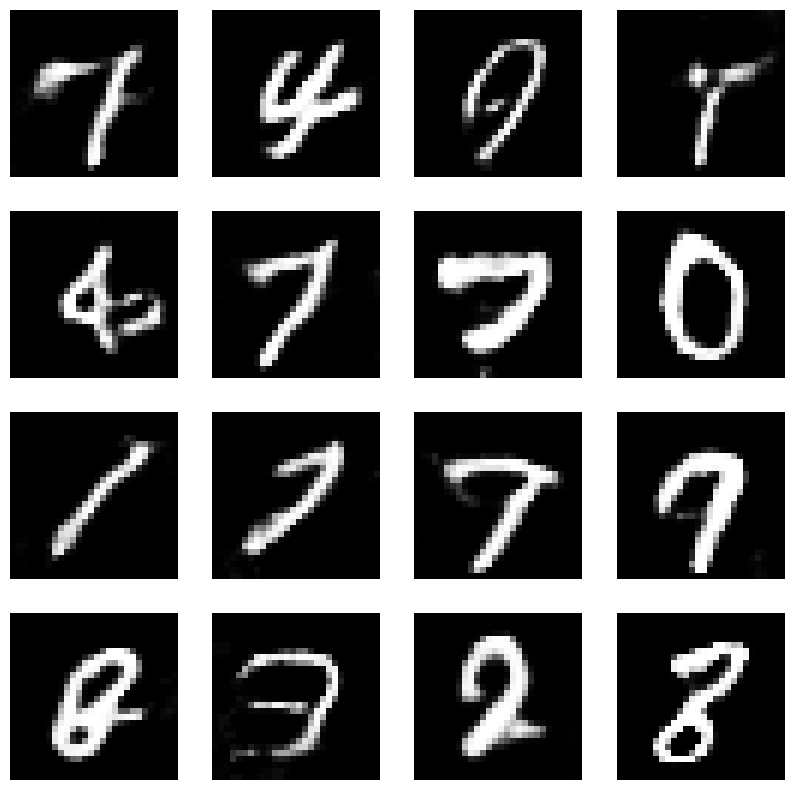

235/235 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - d_loss: 1.3252 - g_loss: 0.7746
Epoch 22/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - d_loss: 1.3260 - g_loss: 0.7746
Epoch 23/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - d_loss: 1.3282 - g_loss: 0.7774
Epoch 24/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - d_loss: 1.3276 - g_loss: 0.7746
Epoch 25/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - d_loss: 1.3243 - g_loss: 0.7756
Epoch 26/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3238 - g_loss: 0.7751

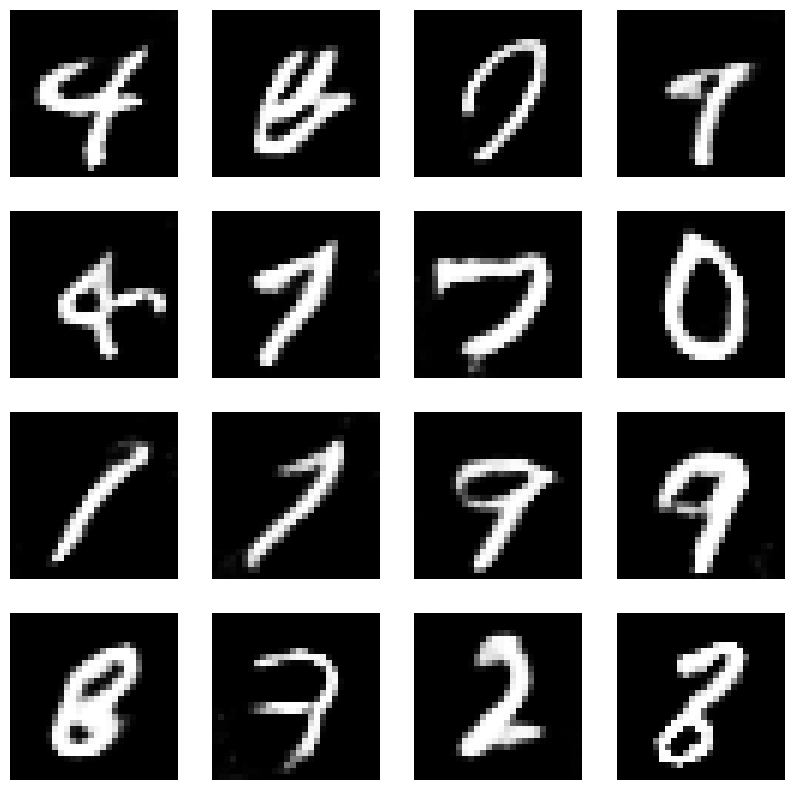

235/235 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - d_loss: 1.3238 - g_loss: 0.7752
Epoch 27/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - d_loss: 1.3275 - g_loss: 0.7771
Epoch 28/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - d_loss: 1.3255 - g_loss: 0.7798
Epoch 29/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - d_loss: 1.3235 - g_loss: 0.7802
Epoch 30/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - d_loss: 1.3224 - g_loss: 0.7802
Epoch 31/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3254 - g_loss: 0.7808

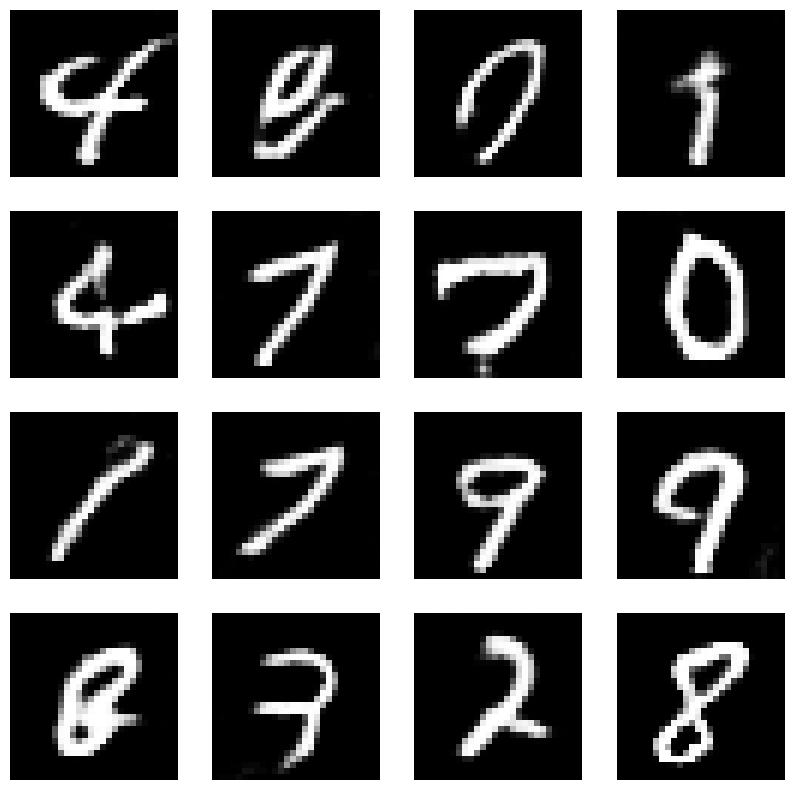

235/235 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - d_loss: 1.3254 - g_loss: 0.7808
Epoch 32/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - d_loss: 1.3241 - g_loss: 0.7803
Epoch 33/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - d_loss: 1.3205 - g_loss: 0.7813
Epoch 34/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - d_loss: 1.3229 - g_loss: 0.7846
Epoch 35/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - d_loss: 1.3212 - g_loss: 0.7803
Epoch 36/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3202 - g_loss: 0.7832

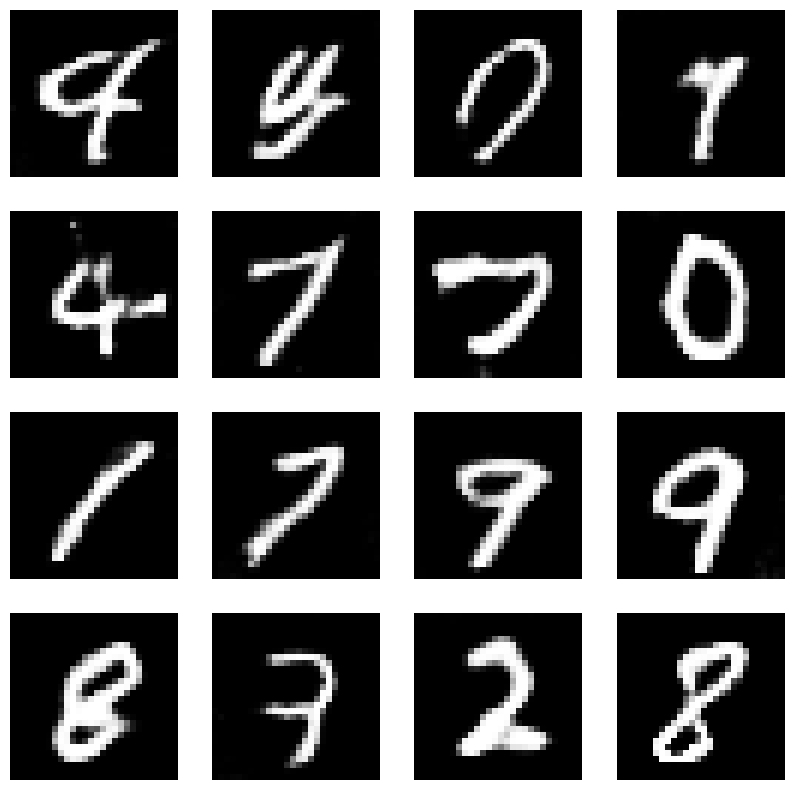

235/235 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - d_loss: 1.3199 - g_loss: 0.7829
Epoch 37/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - d_loss: 1.3226 - g_loss: 0.7828
Epoch 38/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - d_loss: 1.3221 - g_loss: 0.7832
Epoch 39/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - d_loss: 1.3215 - g_loss: 0.7846
Epoch 40/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - d_loss: 1.3147 - g_loss: 0.7806
Epoch 41/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3225 - g_loss: 0.7879

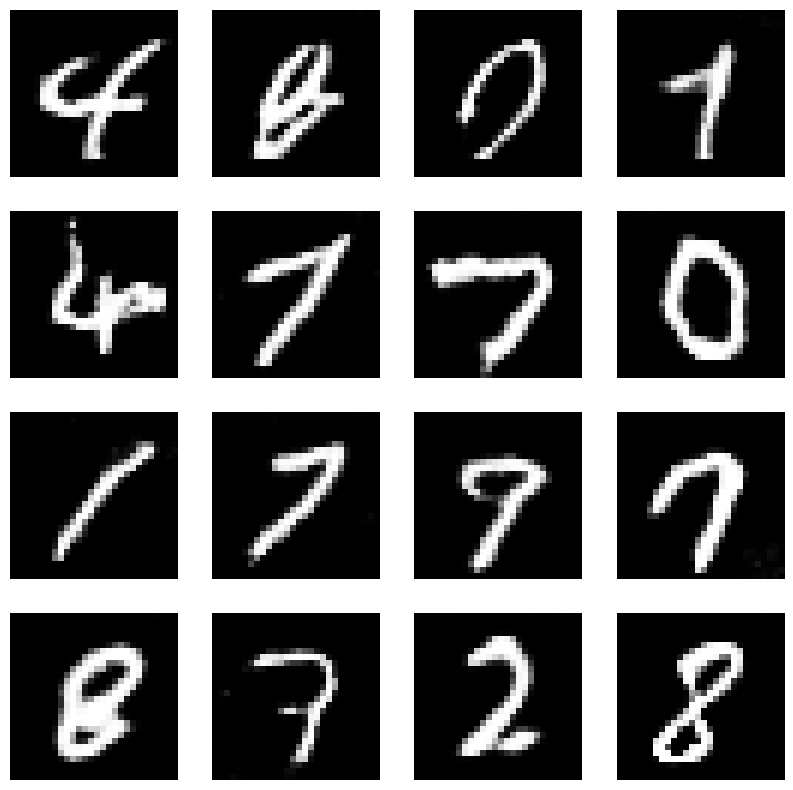

235/235 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - d_loss: 1.3224 - g_loss: 0.7876
Epoch 42/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - d_loss: 1.3247 - g_loss: 0.7883
Epoch 43/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - d_loss: 1.3176 - g_loss: 0.7839
Epoch 44/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 536s 2s/step - d_loss: 1.3227 - g_loss: 0.7857
Epoch 45/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - d_loss: 1.3172 - g_loss: 0.7812
Epoch 46/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3239 - g_loss: 0.7863

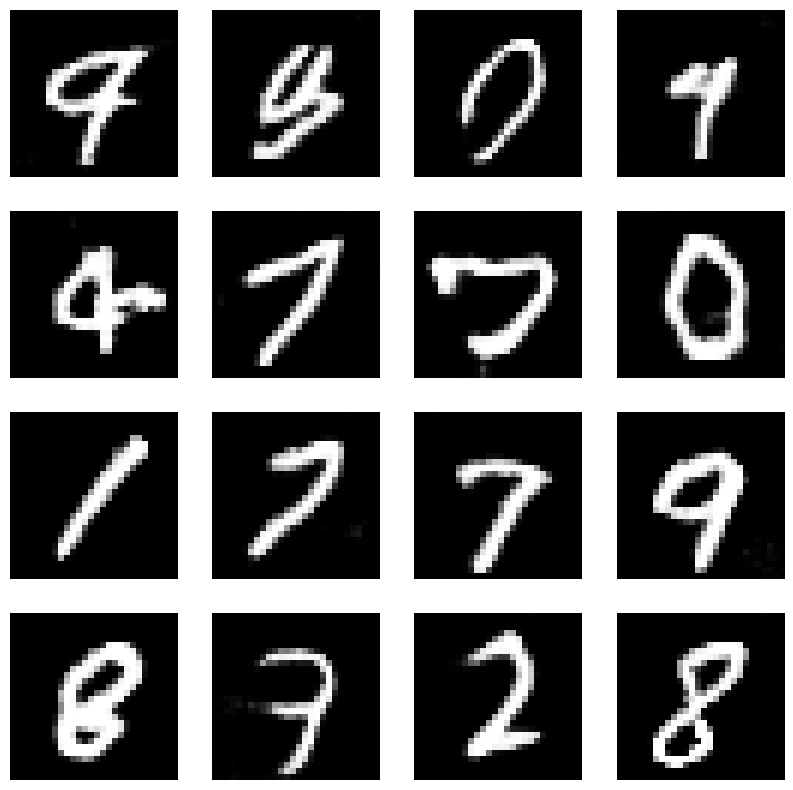

235/235 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - d_loss: 1.3238 - g_loss: 0.7856
Epoch 47/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - d_loss: 1.3188 - g_loss: 0.7826
Epoch 48/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1523s 7s/step - d_loss: 1.3198 - g_loss: 0.7840
Epoch 49/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - d_loss: 1.3217 - g_loss: 0.7877
Epoch 50/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - d_loss: 1.3192 - g_loss: 0.7843
Epoch 51/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3191 - g_loss: 0.7876

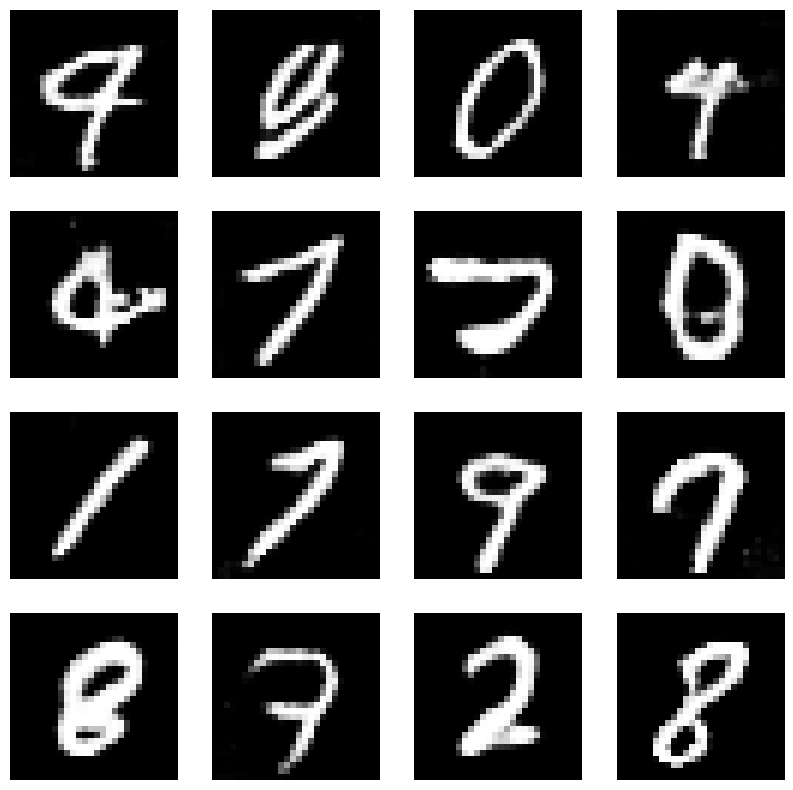

235/235 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - d_loss: 1.3191 - g_loss: 0.7875
Epoch 52/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - d_loss: 1.3184 - g_loss: 0.7887
Epoch 53/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 725s 3s/step - d_loss: 1.3202 - g_loss: 0.7845
Epoch 54/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 785s 3s/step - d_loss: 1.3187 - g_loss: 0.7874
Epoch 55/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 642s 3s/step - d_loss: 1.3202 - g_loss: 0.7865
Epoch 56/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3203 - g_loss: 0.7882

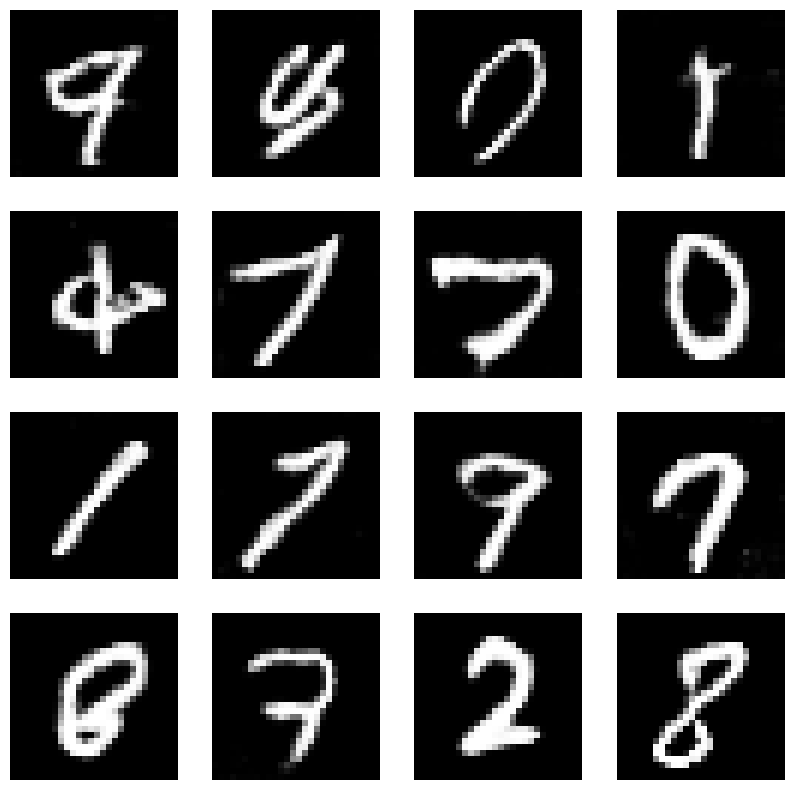

235/235 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - d_loss: 1.3202 - g_loss: 0.7878
Epoch 57/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - d_loss: 1.3173 - g_loss: 0.7889
Epoch 58/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - d_loss: 1.3210 - g_loss: 0.7880
Epoch 59/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - d_loss: 1.3183 - g_loss: 0.7891
Epoch 60/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - d_loss: 1.3184 - g_loss: 0.7887
Epoch 61/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3169 - g_loss: 0.7886

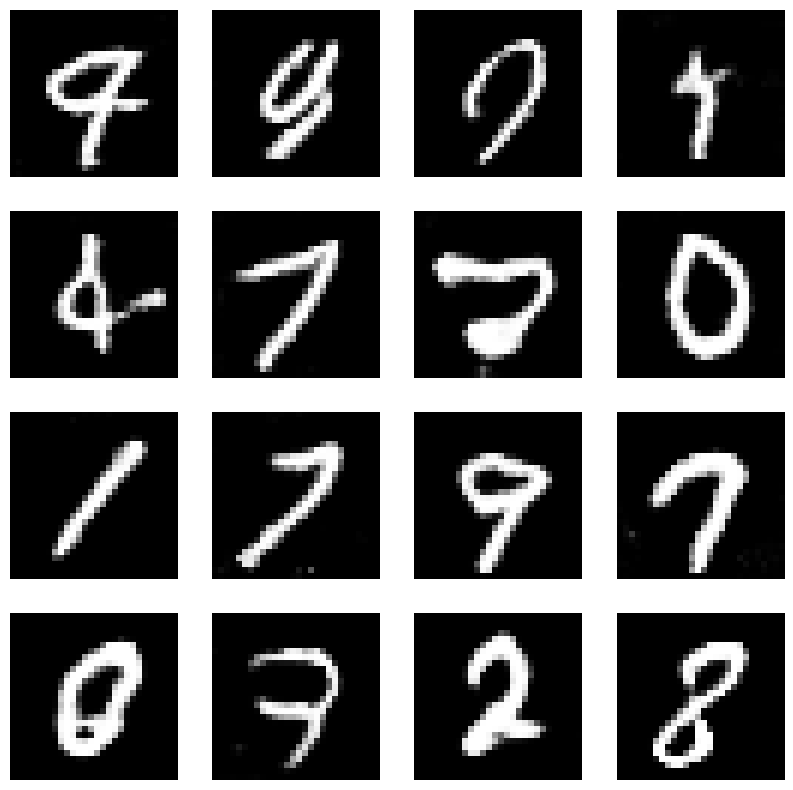

235/235 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - d_loss: 1.3167 - g_loss: 0.7892
Epoch 62/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1624s 7s/step - d_loss: 1.3202 - g_loss: 0.7867
Epoch 63/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - d_loss: 1.3172 - g_loss: 0.7863
Epoch 64/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - d_loss: 1.3191 - g_loss: 0.7931
Epoch 65/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - d_loss: 1.3209 - g_loss: 0.7872
Epoch 66/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3158 - g_loss: 0.7887

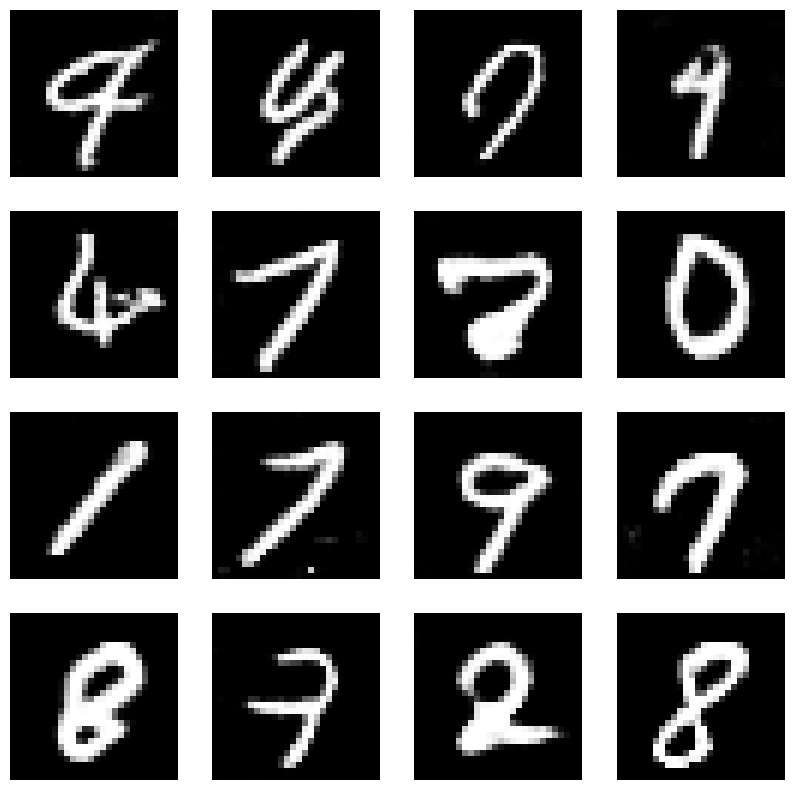

235/235 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - d_loss: 1.3158 - g_loss: 0.7887
Epoch 67/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 652s 3s/step - d_loss: 1.3201 - g_loss: 0.7905
Epoch 68/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 727s 3s/step - d_loss: 1.3148 - g_loss: 0.7874
Epoch 69/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 639s 3s/step - d_loss: 1.3213 - g_loss: 0.7913
Epoch 70/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - d_loss: 1.3193 - g_loss: 0.7915
Epoch 71/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3185 - g_loss: 0.7885

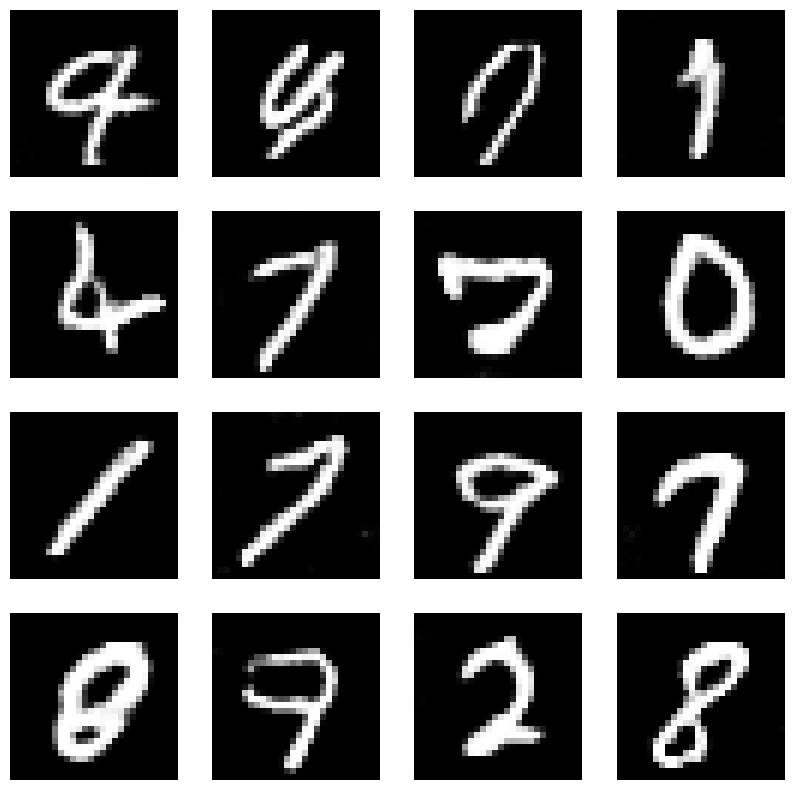

235/235 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - d_loss: 1.3185 - g_loss: 0.7890
Epoch 72/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - d_loss: 1.3180 - g_loss: 0.7903
Epoch 73/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - d_loss: 1.3159 - g_loss: 0.7869
Epoch 74/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - d_loss: 1.3194 - g_loss: 0.7933
Epoch 75/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - d_loss: 1.3204 - g_loss: 0.7930
Epoch 76/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3170 - g_loss: 0.7894

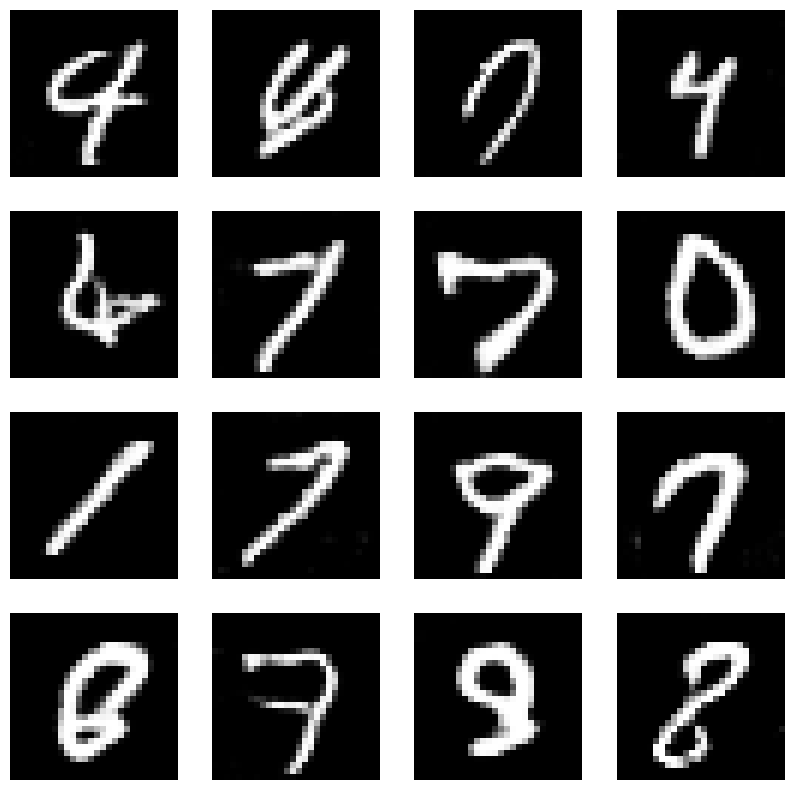

235/235 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - d_loss: 1.3169 - g_loss: 0.7901
Epoch 77/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - d_loss: 1.3157 - g_loss: 0.7931
Epoch 78/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step - d_loss: 1.3162 - g_loss: 0.7892
Epoch 79/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - d_loss: 1.3171 - g_loss: 0.7958
Epoch 80/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - d_loss: 1.3183 - g_loss: 0.7925
Epoch 81/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3180 - g_loss: 0.7898

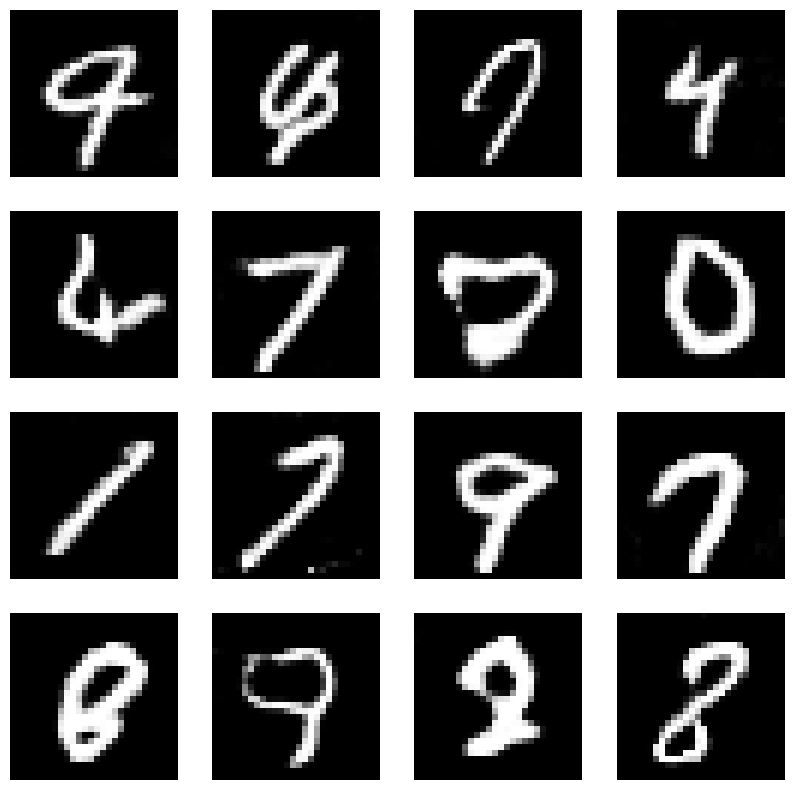

235/235 ━━━━━━━━━━━━━━━━━━━━ 570s 2s/step - d_loss: 1.3179 - g_loss: 0.7896
Epoch 82/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - d_loss: 1.3179 - g_loss: 0.7936
Epoch 83/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - d_loss: 1.3176 - g_loss: 0.7914
Epoch 84/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - d_loss: 1.3159 - g_loss: 0.7915
Epoch 85/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - d_loss: 1.3173 - g_loss: 0.7910
Epoch 86/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.3177 - g_loss: 0.7933

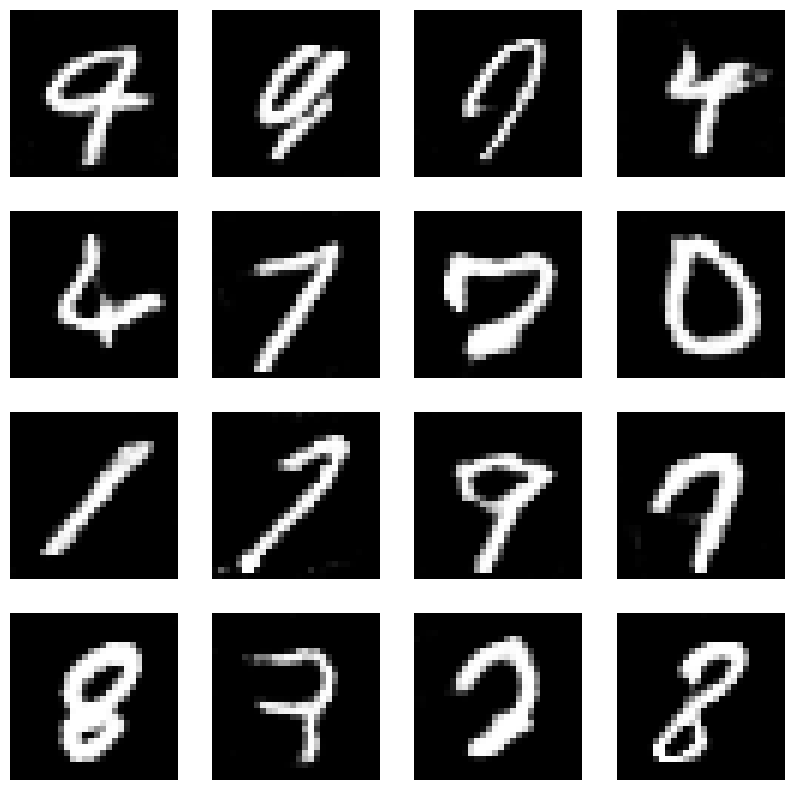

235/235 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - d_loss: 1.3176 - g_loss: 0.7941
Epoch 87/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 648s 3s/step - d_loss: 1.3162 - g_loss: 0.7931
Epoch 88/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 719s 3s/step - d_loss: 1.3149 - g_loss: 0.7918
Epoch 89/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 658s 3s/step - d_loss: 1.3172 - g_loss: 0.7942
Epoch 90/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 710s 3s/step - d_loss: 1.3147 - g_loss: 0.7926
Epoch 91/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - d_loss: 1.3192 - g_loss: 0.7941

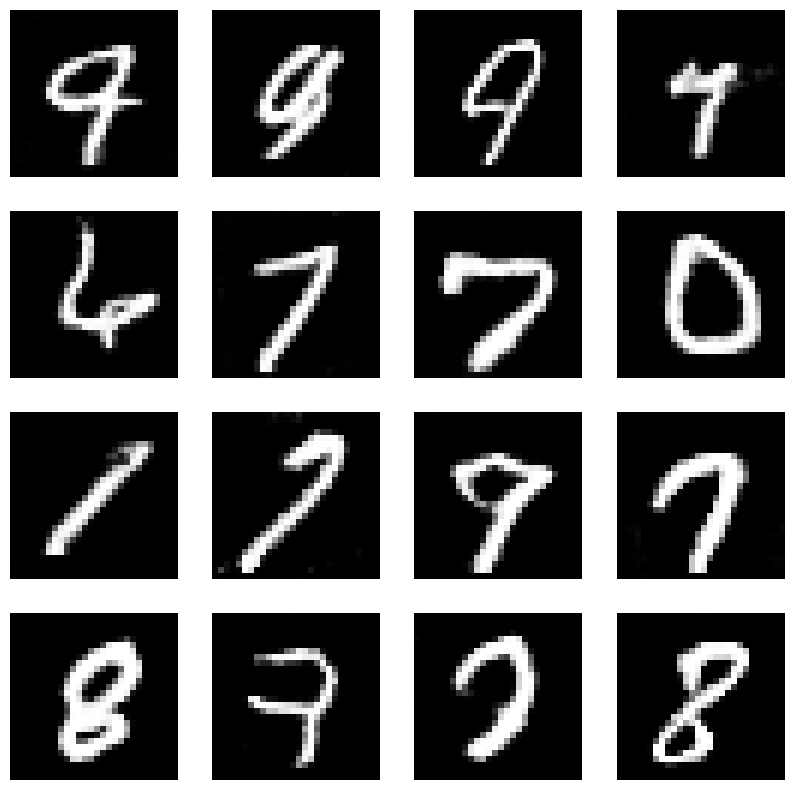

235/235 ━━━━━━━━━━━━━━━━━━━━ 752s 3s/step - d_loss: 1.3191 - g_loss: 0.7935
Epoch 92/100
 17/235 ━━━━━━━━━━━━━━━━━━━━ 15:22 4s/step - d_loss: 1.2966 - g_loss: 0.7956

KeyboardInterrupt: 

In [68]:
history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[ImageCallback()])

In [69]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined